In [1]:
import numpy as np
import pandas as pd 

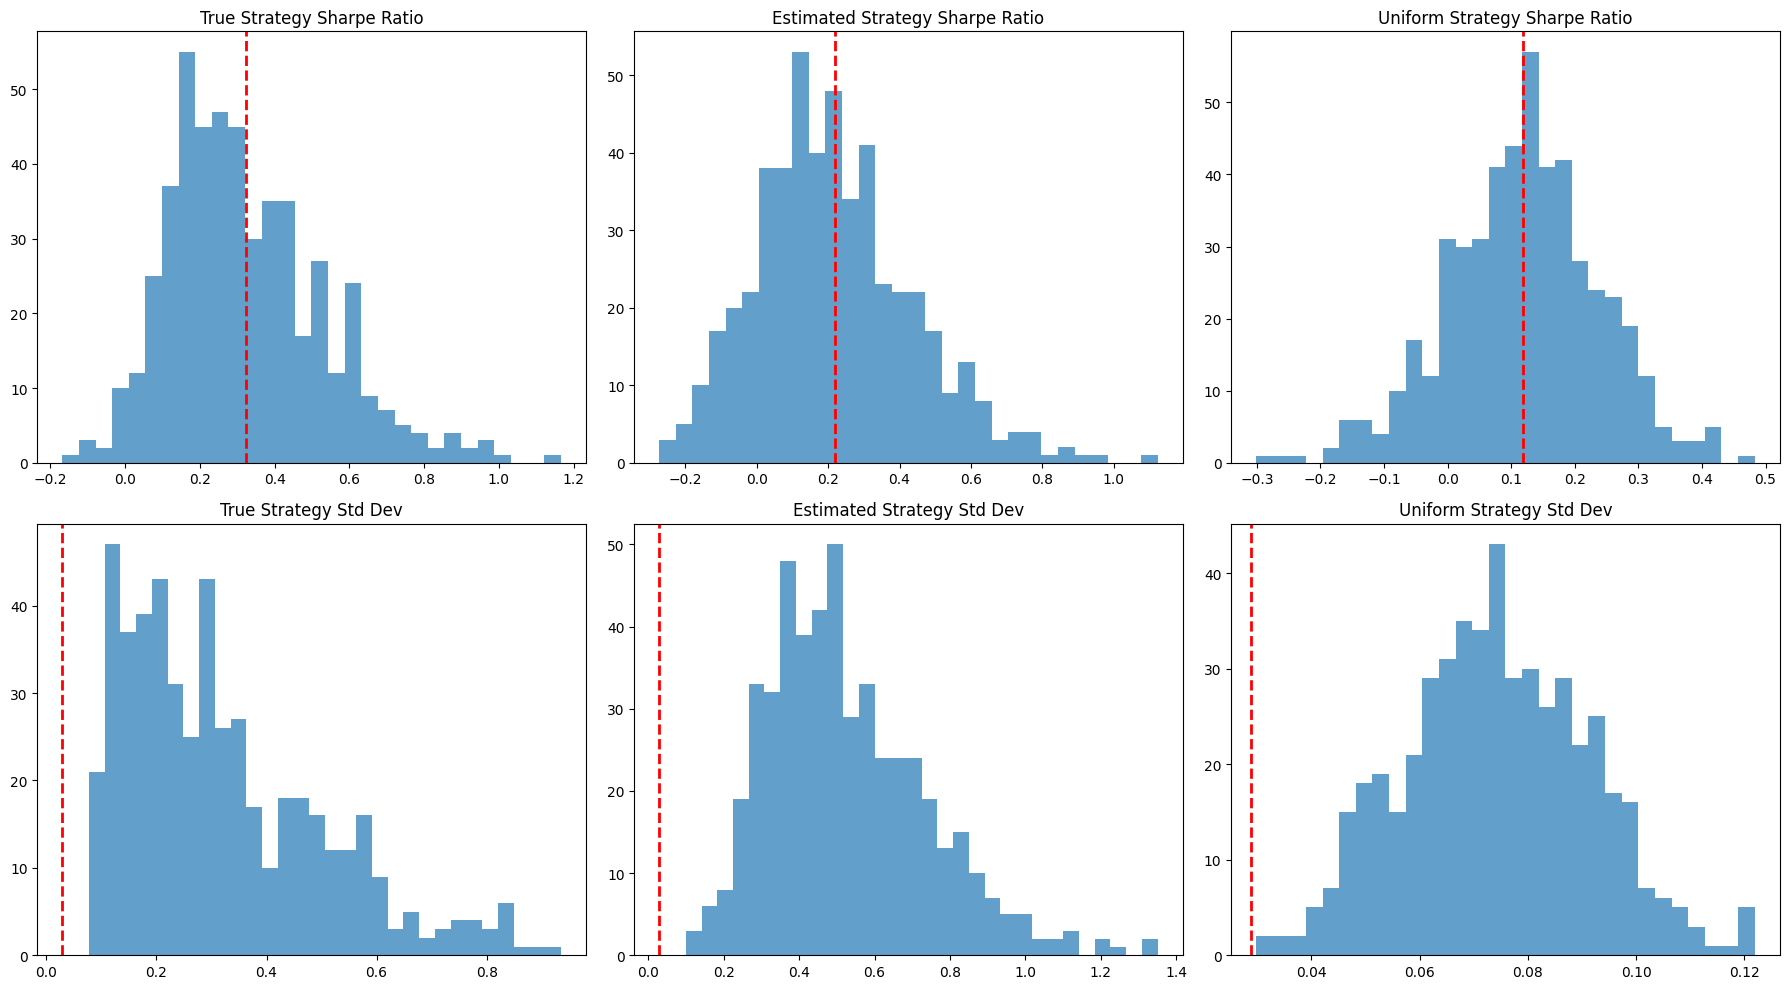

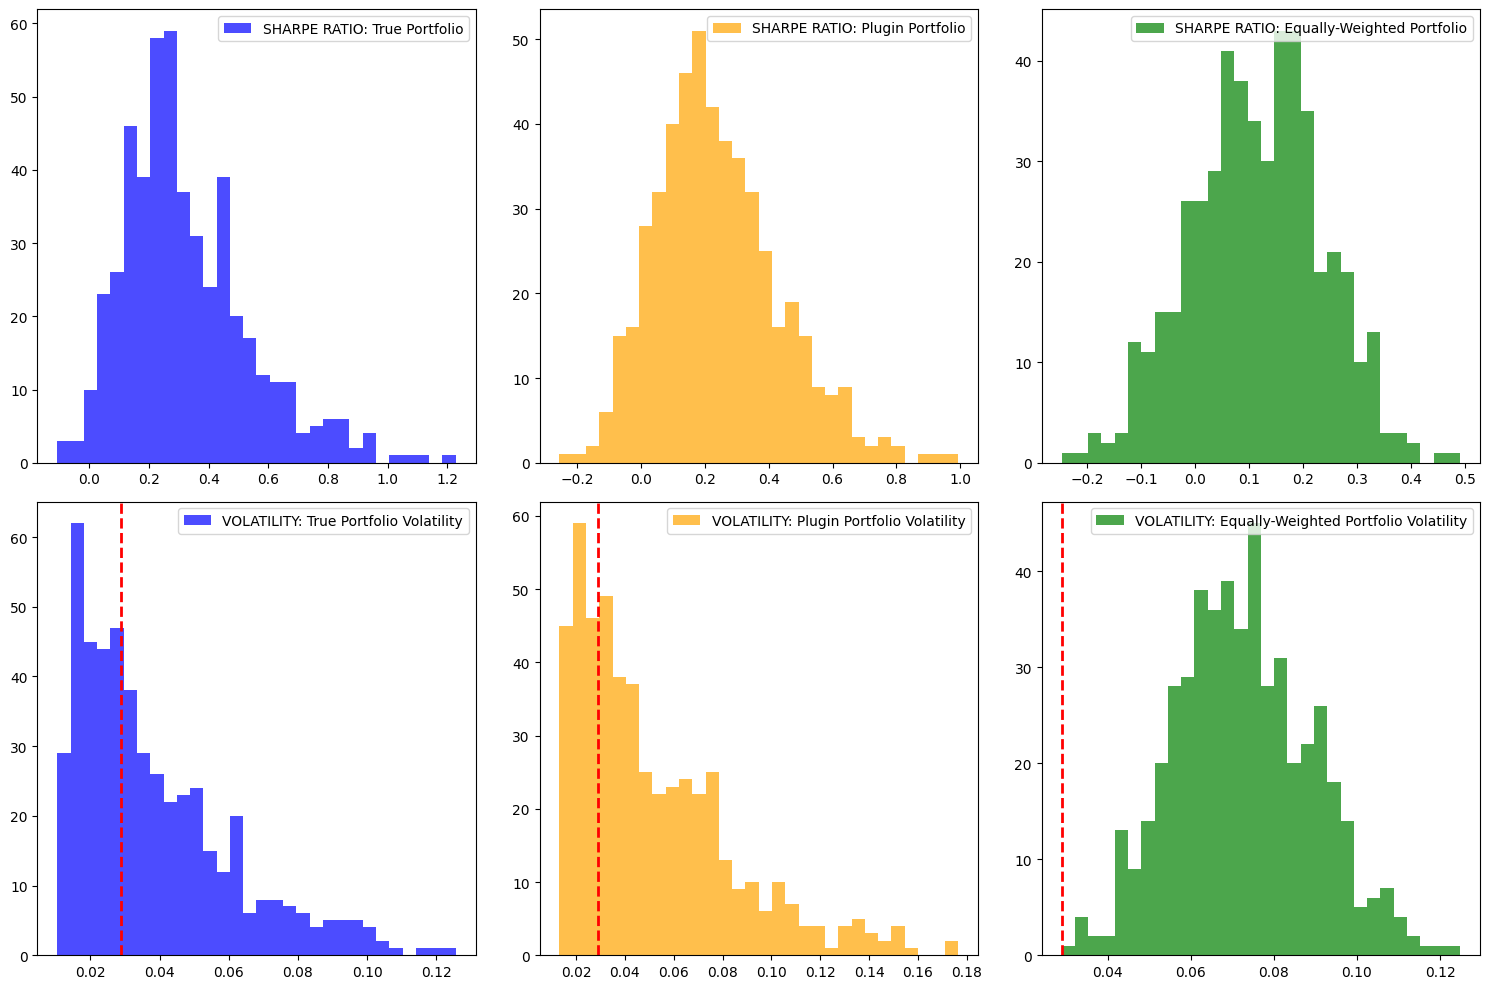

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Simulation parameters
assets = 5
total_periods = 120
estimation_window = 40
simulations = 500
target_volatility = 0.10 / np.sqrt(12)
risk_free_rate = 0.0

# Function to generate returns with a stochastic correlation matrix
def generate_returns(n_assets, n_periods, mu_range, vol_range, base_corr=0.5):
    mus = np.random.uniform(mu_range[0], mu_range[1], n_assets)
    vols = np.random.uniform(vol_range[0], vol_range[1], n_assets)
    corr_matrix = np.random.uniform(base_corr - 0.1, base_corr + 0.1, (n_assets, n_assets))
    corr_matrix = (corr_matrix + corr_matrix.T) / 2
    np.fill_diagonal(corr_matrix, 1)
    cov_matrix = np.diag(vols) @ corr_matrix @ np.diag(vols)
    return np.random.multivariate_normal(mus, cov_matrix, n_periods), mus, cov_matrix

# Function to compute the maximum Sharpe ratio portfolio
def max_sharpe_ratio(weights, mus, cov_matrix, rf):
    returns = np.sum(mus * weights)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (returns - rf) / volatility
    return -sharpe_ratio

# Initial guess and bounds for optimization
initial_weights = np.ones(assets) / assets
bounds = tuple((0, 1) for asset in range(assets))
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

# Storing simulation results
true_sharpe_ratios, plugin_sharpe_ratios, equal_sharpe_ratios = [], [], []
true_vols, plugin_vols, equal_vols = [], [], []

for _ in range(simulations):
    returns, mus, cov_matrix = generate_returns(assets, total_periods, (0.05/12, 0.15/12), (0.05/np.sqrt(12), 0.60/np.sqrt(12)))
    returns_df = pd.DataFrame(returns)
    
    # True portfolio
    true_weights = np.linalg.inv(cov_matrix) @ mus
    true_weights /= np.sum(true_weights)
    true_portfolio_returns = returns_df.dot(true_weights)
    true_sharpe_ratios.append(true_portfolio_returns.mean() / true_portfolio_returns.std())
    true_vols.append(true_portfolio_returns.std())

    # Plugin portfolio using historical estimates
    historical_returns = returns_df[:estimation_window]
    mu_hat = historical_returns.mean()
    sigma_hat = historical_returns.cov()
    # Optimize for weights with maximum Sharpe ratio
    args = (mu_hat, sigma_hat, risk_free_rate)
    result = minimize(max_sharpe_ratio, initial_weights, args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    plugin_weights = result.x
    plugin_portfolio_returns = returns_df[estimation_window:].dot(plugin_weights)
    plugin_sharpe_ratios.append(plugin_portfolio_returns.mean() / plugin_portfolio_returns.std())
    plugin_vols.append(plugin_portfolio_returns.std())

    # Equal-weighted portfolio with periodic rebalancing
    rebalanced_weights = np.ones(assets) / assets
    equal_portfolio_returns = returns_df[estimation_window:].dot(rebalanced_weights)
    # Assume rebalancing occurs, recalculate volatility based on new sigma estimates
    equal_portfolio_vol = np.sqrt(rebalanced_weights.T @ sigma_hat @ rebalanced_weights)
    equal_sharpe_ratios.append(equal_portfolio_returns.mean() / equal_portfolio_vol)
    equal_vols.append(equal_portfolio_vol)

# Create the plots for Sharpe ratios and volatilities
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax[0, 0].hist(true_sharpe_ratios, bins=30, alpha=0.7, color='blue', label='SHARPE RATIO: True Portfolio')
ax[0, 1].hist(plugin_sharpe_ratios, bins=30, alpha=0.7, color='orange', label='SHARPE RATIO: Plugin Portfolio')
ax[0, 2].hist(equal_sharpe_ratios, bins=30, alpha=0.7, color='green', label='SHARPE RATIO: Equally-Weighted Portfolio')

ax[1, 0].hist(true_vols, bins=30, alpha=0.7, color='blue', label='VOLATILITY: True Portfolio Volatility')
ax[1, 1].hist(plugin_vols, bins=30, alpha=0.7, color='orange', label='VOLATILITY: Plugin Portfolio Volatility')
ax[1, 2].hist(equal_vols, bins=30, alpha=0.7, color='green', label='VOLATILITY: Equally-Weighted Portfolio Volatility')

for i in range(3):
    ax[0, i].legend()
    ax[1, i].legend()
    ax[1, i].axvline(target_volatility, color='red', linestyle='dashed', linewidth=2)

plt.tight_layout()
plt.show() 
